# BAO examples

In this notebook we will show how to perform BAO fits to data power spectrum.
Look first at notebooks basic_examples.ipynb to get a flavor of *desilike* mechanisms.

## Fake power spectrum data

In [1]:
import numpy as np

from cosmoprimo.fiducial import DESI

cosmo = DESI()
edges = np.linspace(0., 0.3, 31)
k = (edges[:-1] + edges[1:]) / 2.
nmodes = 4. * np.pi / 3. * (edges[1:]**3 - edges[:-1]**3)
z = 1.
pk = cosmo.get_fourier().pk_interpolator(of='delta_cb')(k, z=z)
b = 2.
f = cosmo.growth_rate(z)
shotnoise = 1 / 5e-4
volume = 1e10

ells = (0, 2, 4)
poles = []
poles.append((b**2 + 2. / 3. * f * b + 1. / 5. * f**2) * pk + shotnoise)
poles.append((4. / 3. * f * b + 4. / 7. * f**2) * pk)
poles.append(8. / 35 * f**2 * pk)
poles = np.array(poles, dtype='f8')

from pypower import PowerSpectrumStatistics
mean = PowerSpectrumStatistics(edges, k, poles, nmodes=nmodes, ells=ells, shotnoise_nonorm=shotnoise, statistic='multipole')
cov = [2. * (2. * np.pi)**3 / (2 * ell + 1) / (volume * nmodes) * poles[0]**2 for ell in ells]
cov = np.diag(np.concatenate(cov, axis=0))

rng = np.random.RandomState(seed=42)
mocks = []
for i in range(1001):
    tmp = mean.deepcopy()
    tmp.power_nonorm.flat[...] = rng.multivariate_normal(mean.power_nonorm.ravel(), cov)
    mocks.append(tmp)
data, mocks = mocks[0], mocks[1:]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## BAO theory and broadbands
The BAO broadband can be parameterized as:
- $k$ powers, $\sum_{i} (k / k_{p})^{i}$
- as sum of TSC or PCS kernels, $\sum_{i} K(k / k_{p} - i)$
where typically $k_{p} = 2\pi / r_{s}$.

/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:23: UserWarning: EisensteinHuNoWiggleEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


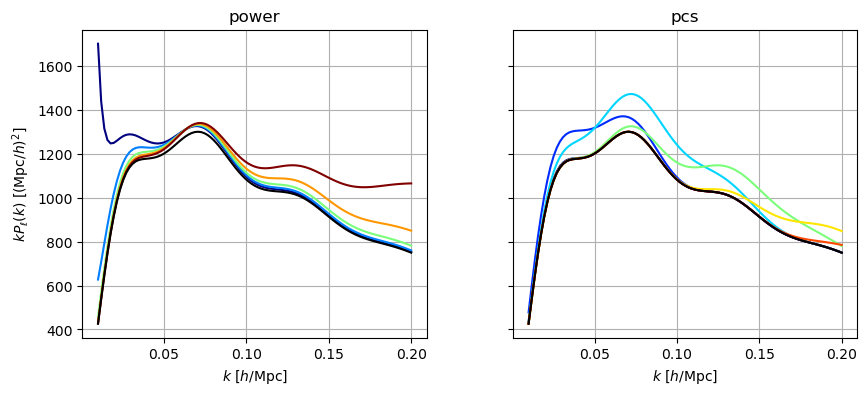

In [2]:
from desilike.theories.galaxy_clustering import BAOPowerSpectrumTemplate, DampedBAOWigglesTracerPowerSpectrumMultipoles

template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI')
theory = DampedBAOWigglesTracerPowerSpectrumMultipoles(template=template, broadband='power')

from matplotlib import pyplot as plt

fig, lax = plt.subplots(1, 2, sharex=False, sharey=True, figsize=(10, 4), squeeze=True)
fig.subplots_adjust(wspace=0.25)

for iax, broadband in enumerate(['power', 'pcs']):
    ax = lax[iax]
    theory.init.update(broadband=broadband)
    names = theory.all_params.names(basename='*l0*')
    cmap = plt.get_cmap('jet', len(names))
    for iname, name in enumerate(names):
        pk = theory(**{name: 5e2 if broadband == 'power' else 1.})
        for ill, ell in enumerate(theory.ells[:1]):
            ax.plot(theory.k, theory.k * pk[ill], color=cmap(iname * 1. / len(names)))
        pk = theory(**{name: 0.})
    ax.plot(theory.k, theory.k * pk[ill], color='k')
    ax.grid(True)
    ax.set_xlabel(r'$k$ [$h/\mathrm{Mpc}$]')
    lax[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
    ax.set_title(broadband)
plt.show()

## BAO likelihood

In [3]:
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import setup_logging

theory.init.update(broadband='pcs')
# Set damping sigmas to zero, as data follows linear pk
for param in theory.init.params.select(basename='sigma*'):
    param.update(value=0., fixed=True)
# Analytically solve for broadband parameters (named 'al*_*')
for param in theory.init.params.select(basename='al*_*'):
    param.update(derived='.auto')
observable = TracerPowerSpectrumMultipolesObservable(data=data, covariance=mocks,
                                                     klim={0: [0.005, 0.2], 2: [0.005, 0.2]},  # fit monopole and quadrupole, between 0.02 and 0.2 h/Mpc
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

setup_logging()

In [4]:
# Note, observable can take as input:
# - data: a (list of) (path to) PowerSpectrumStatistics object, flat array (see example below),
# or dictionary of parameters where to evaluate the theory to take as a mock data vector
# - covariance: a (list of) (path to) mocks, array (covariance matrix), or None (covariance passed to ObservablesGaussianLikelihood instead)

# Example, passing arrays:
ells = (0, 2)
k, pk = data(ell=ells, complex=False, return_k=True) # numpy array
mask = (k > 0.005) & (k < 0.2)
k = k[mask]  # array; one could also provide a list of k arrays, one for each ell
pk = np.ravel([pp[mask] for pp in pk])  # flat array
cov = np.cov([np.ravel([pp[mask] for pp in mock(ell=ells, complex=False)]) for mock in mocks], rowvar=False)  # array
observable = TracerPowerSpectrumMultipolesObservable(data=pk,
                                                     covariance=cov,
                                                     ells=ells,
                                                     k=k,
                                                     shotnoise=shotnoise,
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observables=[observable])

## Fit
Let us perform some likelihood (actually posterior, including parameter priors) profiling.

In [5]:
from desilike.profilers import MinuitProfiler

# Seed used to decide on starting point
profiler = MinuitProfiler(likelihood, seed=42)
# Find best fit, starting from 3 different starting points
# NOTE: With MPI, these runs are performed in parallel
profiles = profiler.maximize(niterations=3)

[000000.13] [0/1] 11-02 10:21  MinuitProfiler            INFO     Varied parameters: ['qpar', 'qper', 'b1'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter loglikelihood of <desilike.likelihoods.base.SumLikelihood object at 0x7f11d33eba90> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f11d337f160>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter logprior of <desilike.likelihoods.base.SumLikelihood object at 0x7f11d33eba90> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f11d337f160>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[000001.33] [0/1] 11-02 10:21  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000003.51] [0/1] 11-02 10:21  Differentiation           INFO     Differentiation will evaluate 1 points.
[000005.79] [0/1] 11-02 10:21  TaskManager               INFO     Entering TaskManager with 1 workers.


In [6]:
print(profiles.to_stats(tablefmt='pretty'))

+--------------------------------------+--------+---------+--------+
| chi2 / (38 - 17) = 18.55 / 21 = 0.88 | varied | bestfit | error  |
+--------------------------------------+--------+---------+--------+
|                 qpar                 |  True  | 1.0023  | 0.0038 |
|                 qper                 |  True  | 0.9978  | 0.0069 |
|                  b1                  |  True  |  1.959  | 0.069  |
|                al0_-1                |  True  |   3.5   |        |
|                al0_0                 |  True  |  0.21   |        |
|                al0_1                 |  True  |  0.10   |        |
|                al0_2                 |  True  |  0.18   |        |
|                al0_3                 |  True  |  0.074  |        |
|                al0_4                 |  True  |  0.69   |        |
|                al0_5                 |  True  |  -950   |        |
|                al2_-1                |  True  |  0.49   |        |
|                al2_0            

[000019.11] [0/1] 11-02 10:21  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000019.11] [0/1] 11-02 10:21  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000019.21] [0/1] 11-02 10:21  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral
[000019.21] [0/1] 11-02 10:21  matplotlib.mathtext       INFO     Substituting symbol \perp from STIXGeneral


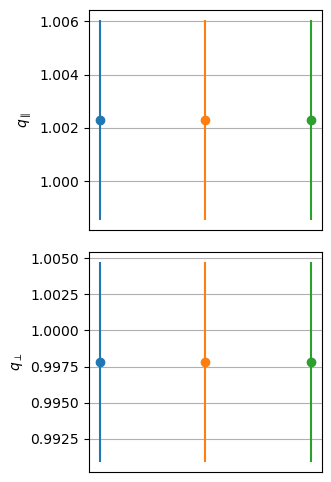

In [7]:
from desilike.samples import plotting
plotting.plot_aligned_stacked(profiles, params=['qpar', 'qper']);

/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter loglikelihood of <desilike.likelihoods.base.SumLikelihood object at 0x7f11d3281c60> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f11d337f160>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter logprior of <desilike.likelihoods.base.SumLikelihood object at 0x7f11d3281c60> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7f11d337f160>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[000019.72] [0/1] 11-02 10:21  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000020.41] [0/1] 11-02 10:21  Differentiation           INFO     Differentiation will evaluate 1 points.


/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/observables/galaxy_clustering/power_spectrum.py:293: UserWarning: plot_wiggles is deprecated, use plot_bao instead
  warnings.warn('plot_wiggles is deprecated, use plot_bao instead')


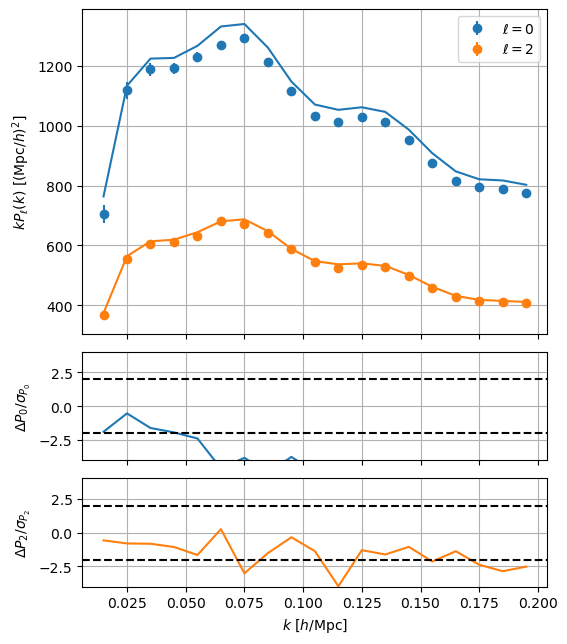

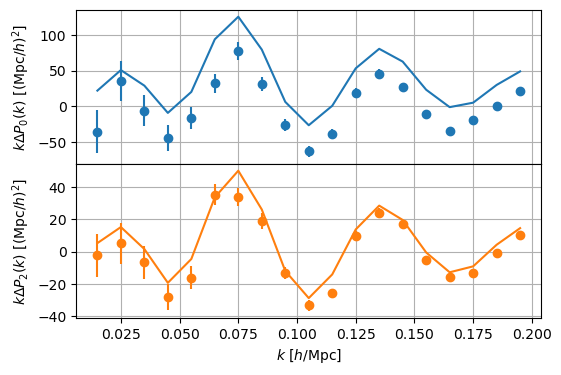

In [8]:
likelihood(**profiles.bestfit.choice(input=True))
observable.plot()
observable.plot_wiggles();

In [9]:
print(profiles.bestfit.choice(input=True))

{'qpar': 1.0022996085552522, 'qper': 0.9978114744524128, 'b1': 1.9592920541745793, 'al0_-1': 3.495775880267096, 'al0_0': 0.2050119374414938, 'al0_1': 0.10164216147040743, 'al0_2': 0.18171861471722198, 'al0_3': 0.07409867485459247, 'al0_4': 0.6851921374273483, 'al0_5': -947.7199909496188, 'al2_-1': 0.48579264791318383, 'al2_0': -0.016929686858409742, 'al2_1': 0.056795022325515615, 'al2_2': -0.01519392360055817, 'al2_3': 0.09506201785287847, 'al2_4': -0.1910789042104685, 'al2_5': 333.6858226377796}


## Detection level

In [9]:
likelihood()
template = BAOPowerSpectrumTemplate(z=z, fiducial='DESI', apmode='qiso', only_now=True)
theory.init.update(template=template)

profiler = MinuitProfiler(likelihood, seed=42)
grid = np.linspace(0.8, 1.2, 31)
profiler.maximize(niterations=1)
profiler.profile(params=['qiso'], grid=grid)
profiles_nowiggle = profiler.profiles

[000022.72] [0/1] 11-02 09:22  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter loglikelihood of <desilike.likelihoods.base.SumLikelihood object at 0x7fb1d314cb50> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7fb1d322ef50>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter logprior of <desilike.likelihoods.base.SumLikelihood object at 0x7fb1d314cb50> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7fb1d322ef50>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[000023.48] [0/1] 11-02 09:22  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000025.31] [0/1] 11-02 09:22  Differentiation           INFO     Differentiation will evaluate 1 points.
[000026.60] [0/1] 11-02 09:22  TaskManager               INFO     Entering TaskManager with 1 workers.
[000032.49] [0/1] 11-02 09:22  TaskManager               INFO     Entering TaskManager with 1 workers.
[000032.55] [0/1] 11-02 09:22  TaskManager               INFO     Entering TaskManager with 1 workers.


In [10]:
template.init.update(only_now=False)

profiler = MinuitProfiler(likelihood, seed=42)
profiler.maximize(niterations=1)
print(profiler.profiles.to_stats(tablefmt='pretty'))

profiler.profile(params=['qiso'], grid=grid)
profiles = profiler.profiles

[000072.28] [0/1] 11-02 09:23  MinuitProfiler            INFO     Varied parameters: ['qiso', 'b1'].


/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter loglikelihood of <desilike.likelihoods.base.SumLikelihood object at 0x7fb1d2d985e0> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7fb1d322ef50>.
  if self.mpicomm.rank == 0: warnings.warn(msg)
/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py:162: UserWarning: Derived parameter logprior of <desilike.likelihoods.base.SumLikelihood object at 0x7fb1d2d985e0> is already derived in <desilike.likelihoods.base.ObservablesGaussianLikelihood object at 0x7fb1d322ef50>.
  if self.mpicomm.rank == 0: warnings.warn(msg)


[000072.93] [0/1] 11-02 09:23  Differentiation           INFO     Varied parameters: ['al0_-1', 'al0_0', 'al0_1', 'al0_2', 'al0_3', 'al0_4', 'al0_5', 'al2_-1', 'al2_0', 'al2_1', 'al2_2', 'al2_3', 'al2_4', 'al2_5'].
[000074.85] [0/1] 11-02 09:23  Differentiation           INFO     Differentiation will evaluate 1 points.
[000076.04] [0/1] 11-02 09:23  TaskManager               INFO     Entering TaskManager with 1 workers.
+--------------------------------------+--------+---------+--------+
| chi2 / (38 - 16) = 19.40 / 22 = 0.88 | varied | bestfit | error  |
+--------------------------------------+--------+---------+--------+
|                 qiso                 |  True  | 1.0035  | 0.0036 |
|                  b1                  |  True  |  1.949  | 0.069  |
|                al0_-1                |  True  |   3.6   |        |
|                al0_0                 |  True  |  0.25   |        |
|                al0_1                 |  True  |  0.10   |        |
|                al0_2  

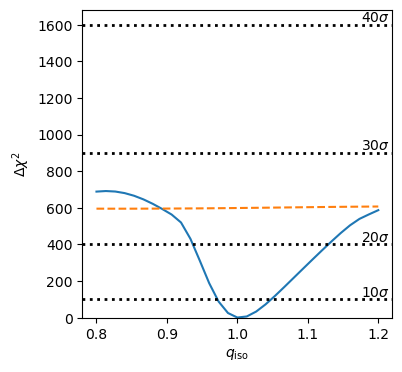

In [11]:
plotting.plot_profile_comparison(profiles, profiles_nowiggle, cl=[10, 20, 30, 40]);

## Sampling
Let us draw MC samples of the likelihood (actually posterior, including parameter priors).

In [12]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, save_fn='_tests/chain_bao_*.npy', seed=42)
sampler.run(min_iterations=500, check={'max_eigen_gr': 0.05, 'stable_over': 1})

[000124.22] [0/1] 11-02 09:24  EmceeSampler              INFO     Varied parameters: ['qiso', 'b1'].
[000124.77] [0/1] 11-02 09:24  TaskManager               INFO     Entering TaskManager with 1 workers.
emcee: Exception while calling your likelihood function:
  params: [[1.00423117 1.83612016]
 [1.00597963 1.93233302]
 [1.00916228 2.0447454 ]]
  args: []
  kwargs: {}
  exception:
[000204.69] [0/1] 11-02 09:25  Exception                 CRITICAL 
Traceback (most recent call last):
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/samplers/base.py", line 402, in _run_batch
    chain = self._run_one(start[ichain], niterations=niterations, **kwargs)
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/samplers/emcee.py", line 99, in _run_one
    for _ in self.sampler.sample(initial_state=start, iterations=niterations, progress=progress, store=True, thin_by=thin_by, skip_initial_state_check=False):
  File "/home/adematti/anaconda3/envs/cosmodesi-main/lib/

Traceback (most recent call last):
  File "/home/adematti/anaconda3/envs/cosmodesi-main/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/samplers/base.py", line 59, in wrapper
    toret[mask] = func(self, values)
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/samplers/base.py", line 149, in logposterior
    self.pipeline.mpicalculate(**points.to_dict())
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py", line 297, in mpicalculate
    self.calculate(**{name: value[ivalue] for name, value in chunk_params.items()})
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/base.py", line 249, in calculate
    toret = self.more_calculate()
  File "/home/adematti/Bureau/DESI/NERSC/cosmodesi/desilike/desilike/likelihoods/base.py", line 128, in _solve
    solve_likelihoods = [likelihood for likelih

KeyboardInterrupt: 

In [ ]:
chain = sampler.chains[0].remove_burnin(0.5)[::10]
print(chain.to_stats(tablefmt='pretty'))

In [ ]:
from desilike.samples import plotting
plotting.plot_triangle(chain, markers={'qiso': 1.})

## Trick: project out the broadband terms from the precision matrix

Since the gradient of the BAO model w.r.t. broadband parameters is constant (does not depend on the other model parameters), we can just assign an infinite variance to these modes, i.e. redefine the precision matrix $\mathbf{C}^{-1}$ as: $\mathbf{C}^{-1} - \mathbf{C}^{-1} \mathbf{T} \mathbf{H}^{-1} \mathbf{T}^{T} \mathbf{C}^{-1}$ where $\mathbf{H} = \mathbf{T}^{T} \mathbf{C}^{-1} \mathbf{T} + \mathbf{P}$ is the Hessian, $\mathbf{P}$ the prior covariance on template parameters.

In [ ]:
from desilike.samplers import EmceeSampler

for param in likelihood.all_params.select(basename='al*_*'):
    param.update(derived='.prec')
sampler = EmceeSampler(likelihood, seed=42)
sampler.run(min_iterations=500, check={'max_eigen_gr': 0.05, 'stable_over': 1})

In [ ]:
chain_prec = sampler.chains[0].remove_burnin(0.5)[::10]
print(chain_prec.to_stats(tablefmt='pretty'))

from desilike.samples import plotting
plotting.plot_triangle([chain, chain_prec], markers={'qiso': 1.})

## Post-processing
Let's use this BAO measurement to put constraints on $\Omega_{m}$.

In [ ]:
from desilike.observables.galaxy_clustering import BAOCompressionObservable
observable = BAOCompressionObservable(data=chain, covariance=chain, z=z, quantities=['qiso'], fiducial='DESI')
likelihood = ObservablesGaussianLikelihood(observables=[observable])

In [ ]:
from desilike.samplers import EmceeSampler

sampler = EmceeSampler(likelihood, seed=42)
sampler.run(check={'max_eigen_gr': 0.02})

In [ ]:
from desilike.samples import plotting
chain = sampler.chains[0].remove_burnin(0.4)
fiducial = observable.extractor.fiducial
plotting.plot_triangle(chain, markers={'Omega_m': fiducial.Omega0_m})